# W24 CS 480/680 assignment 1 (coding part)


- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run before submission.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- Submit your completed version of this notebook.



## Implement Your Own Perceptron

In this question, you are asked to implement the **Perceptron** algorithm and test with a classification task on the adult dataset. Please refer to the [dataset webpage](https://archive.ics.uci.edu/dataset/53/iris) for details on the dataset, and consult the lecture slides and suggested readings for details on the Perceptron algorithm.

- `scikit-learn` or other off-the-shelf Perceptron libraries are not allowed to use.

- Please note that `class` column is the label of the dataset. The labellings have three possible values. So you need to implement a multi-class extension of Perceptron.

- Recording the accuracy on the training dataset when you train the Perceptron model on the training data, as an iteration. Repeat this step for 10 times.

- It is required that you split the dataset into training/testing datasets (80% and 20%, respectively), and we will deduct marks if you don't.

- You will get full marks for
    - Correctly split data into training set and testing set.
    - Correctly implement the perceptron algorithm.
    - Correctly handle multiple class.
    - A plot on training accuracy vs number of iterations, that relects the progress of the training.
    - Final reported accuracy (on the test dataset).

In [14]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# TODO: add any other package you need

# Download the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
filename = 'iris.csv'
urllib.request.urlretrieve(url, filename)

# Load the dataset into a Pandas dataframe
column_names = [
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'
]
data = pd.read_csv(filename, names=column_names)


In [15]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Code for dataset splitting (training-testing):

In [16]:
# TODO: your implementation

#convert to np
data_np = data.to_numpy()
print(np.shape(data_np))

#two ways to get unique classes
# unique_classes = data["class"].unique()
unique_classes = np.unique(data_np[:, -1])
print(unique_classes)


# Separate features and labels
X = data_np[:, :-1].astype(np.float64)   # all rows, all columns except the last one(class)
y = data_np[:, -1]   # all rows, only the last column(class)


# Split dataset into training and testing sets
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(X.shape[0] * (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Display the sizes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# print(X_train[:5])
# print(X_train.dtype)

(150, 5)
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
(120, 4) (30, 4) (120,) (30,)


Code for implemeting the Perceptron algorithm:
- You can either implement it as an class/object or implement the training function and the prediction function.

In [17]:
from os import XATTR_SIZE_MAX
# TODO: your implementation
class Perceptron:
    # def __init__(self, no_of_inputs, epochs=10, learning_rate=0.01):
    def __init__(self, no_of_inputs):
        #weights initialized to zero
        self.weights = np.zeros(no_of_inputs)
        #bias initialized ot zero
        self.bias = 0

    def predict(self, inputs):
        # Ensure inputs is a 2D array
        if inputs.ndim == 1:
            inputs = inputs.reshape(1, -1)

        # Calculate the weighted sum (vectorized for multiple inputs)
        total_sum = np.dot(inputs, self.weights) + self.bias

        # Apply the step function (1 if positive, -1 otherwise)
        return np.where(total_sum > 0, 1, -1)

    def score(self, inputs):
        # Ensure inputs is a 2D array
        if inputs.ndim == 1:
            inputs = inputs.reshape(1, -1)

        # Calculate the weighted sum (vectorized for multiple inputs)
        total_sum = np.dot(inputs, self.weights) + self.bias

        # Apply the step function (1 if positive, 0 otherwise)
        return total_sum

    def train(self, training_inputs, labels):
        for x_i, y_i in zip(training_inputs, labels):
            if y_i * (np.dot(x_i, self.weights) + self.bias) <= 0:
                result = y_i * x_i
                # self.weights += y_i * x_i
                self.weights += y_i * x_i # Cast the operation result to float64
                self.bias += y_i


    def train_with_plot(self, training_inputs, labels):
        accuracy_per_epoch = []  # To store accuracy at the end of each epoch

        for _ in range(self.epochs):
            for x_i, y_i in zip(training_inputs, labels):
                if y_i * (np.dot(x_i, self.weights) + self.bias) <= 0:
                    self.weights += y_i * x_i
                    self.bias += y_i

            # Calculate and store accuracy at the end of this epoch
            predictions = self.predict(training_inputs)
            accuracy = np.mean(predictions == labels)
            accuracy_per_epoch.append(accuracy)

        # Plotting accuracy over epochs
        plt.plot(accuracy_per_epoch)
        plt.xlabel('Epoch')
        plt.ylabel('Training Accuracy')
        plt.title('Perceptron Training Accuracy Over Epochs')
        plt.show()

        return accuracy_per_epoch  # Optional: return accuracies for further analysis

    def evaluate_accuracy(self, test_inputs, test_labels):
        predictions = self.predict(test_inputs)
        accuracy = np.mean(predictions == test_labels)
        return accuracy



Code for implementing a wrapper function:
- Handling multi-class extension
- Feeding in data and call Perceptron training function
- Outputing multiple Perceptrons that are trained

In [18]:
# TODO: your implementation
def train_one_vs_all(X, y, unique_classes, epochs=10):
    accuracy_per_epoch = []
    perceptrons = []
    binary_labels = []
    for class_val in unique_classes:
        binary_label = np.where(y == class_val, 1, -1)
        binary_labels.append(binary_label)
        perceptron = Perceptron(no_of_inputs=X.shape[1])
        perceptrons.append(perceptron)


    for _ in range(epochs):
        for i in range(len(perceptrons)):
            # Create binary labels for the current class
            binary_label = binary_labels[i]
            # Train a perceptron for the current class
            perceptron = perceptrons[i]
            perceptron.train(X, binary_label)

        predictions = predict_one_vs_all(perceptrons, X)
        #convert predication index back to labels
        predicted_labels = unique_classes[predictions]
        accuracy = np.mean(predicted_labels == y)
        accuracy_per_epoch.append(accuracy)

    # Plotting accuracy over epochs
    plt.plot(accuracy_per_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.title('Perceptron Training Accuracy Over Epochs')
    plt.savefig('training_accuracy.png', dpi=300)
    plt.show()


    return perceptrons

def predict_one_vs_all(perceptrons, X):
    scores = np.array([perceptron.score(X) for perceptron in perceptrons])
    # print(scores.shape)
    return np.argmax(scores, axis=0)


Code for testing and ploting:



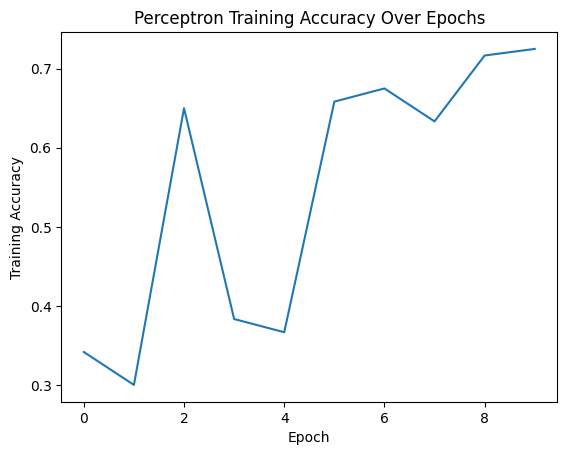

Test accuracy: 86.67%


In [21]:
# TODO: plot the accuracy against the number of iterations
# TODO: report the final accuracy

def evaluate_accuracy(perceptrons, X_test, y_test):
    # Predict the class with the highest score for each test sample
    predictions = predict_one_vs_all(perceptrons, X_test)
    # Convert predictions back to original class labels if necessary
    # This step is needed if your perceptrons were trained with labels encoded differently from y_test
    predicted_labels = unique_classes[predictions]
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == y_test)
    return accuracy

ova_perceptrons = train_one_vs_all(X_train, y_train, unique_classes)
accuracy = evaluate_accuracy(ova_perceptrons, X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")